In [1]:
%run header.py data/ASIC-2-FPGA

Python version: 3.6.1 |Anaconda 4.4.0 (64-bit)| (default, May 11 2017, 13:25:24) [MSC v.1900 64 bit (AMD64)]
pandas version: 0.20.1
matplotlib version: 2.0.2
NumPy version: 1.14.1
SciPy version: 1.0.0
IPython version: 5.3.0
scikit-learn version: 0.19.1
-------------------------


In [2]:
df = gd.data_v4['interpolation']
df = df.drop(['index'], axis=1)

In [3]:
df.head(2)

,AREA,state,FU,REG,MUX,DEC,pin_pair,net,max,min,ave,MISC,MEM,CP_delay,sim,Pmax,Pmin,Pave,Latency,BlockMemoryBit,DSP,FU.1,ATTR,ARRAY_1,ARRAY_2,ARRAY_3,ARRAY_4,ARRAY_5,LOOP_1,LOOP_2,LOOP_3,LOOP_4,LOOP_5,Attr,Attr_with_L,Slices
0,42430,5,33685,1800,6798,0,81979,34980,5,5,5.0,147,0,21.5276ns,-,-,-,-,17,-,-,0,Cyber,array=REG,array=EXPAND+array_index=const,array=EXPAND+array_index=const,array=EXPAND+array_index=const,array=EXPAND+array_index=const,folding=1,unroll_times=4,unroll_times=all,folding=0,folding=0,ATTR=Cyber;ARRAY_1=array=REG;ARRAY_2=array=EXP...,ATTR=Cyber;ARRAY_1=array=REG;ARRAY_2=array=EXP...,7716
1,75164,5,66916,1824,6359,0,131261,58711,5,5,5.0,65,0,11.4612ns,-,-,-,-,20,-,-,100,Cyber,array=LOGIC,array=EXPAND+array_index=const,array=EXPAND+array_index=const,array=RAM,array=EXPAND+array_index=const,unroll_times=0,unroll_times=2,unroll_times=4,unroll_times=4,unroll_times=0,ATTR=Cyber;ARRAY_1=array=LOGIC;ARRAY_2=array=E...,ATTR=Cyber;ARRAY_1=array=LOGIC;ARRAY_2=array=E...,11749


In [4]:
df['PF_ASIC'] = is_pareto_efficient(df[['Latency', 'AREA']].as_matrix())
df['PF_FPGA'] = is_pareto_efficient(df[['Latency', 'Slices']].as_matrix())

In [5]:
def in_range(x, interval, equal_latency=True):
    """Check if a value is in a set of intervals.
    
    Parameters
    ----------
    x: tuple
        The value to be checked.
        x[0] is AREA, x[1] is Latency.
        
    interval: list containing tuple(s) as elements
        One element contains:
            - lower bound
            - upper bound
            - Latency
        
    equal_latency: bool, optional (default=True)
        If True, the new designs must have the same latency
        with the Pareto optimal.
        
    Returns
    -------
    True, if x falls in one of the tuples.
    
    Examples
    --------
    >>> x = (10, 6)
    >>> interval = [(1, 4, 7), (7, 9, 6), (20, 30, 6)]
    >>> in_range(x, interval)
    False
    
    >>> interval = [(1, 4, 7), (7, 11, 6), (20, 30, 6)]
    >>> in_range(x, interval)
    True
    """
    is_in = False
    for xx in interval:
        if xx[0] <= x[0] <= xx[1]:
            is_in = True
            if equal_latency and x[1] != xx[2]:
                is_in = False
            else:
                break
    return is_in

In [6]:
def generate_interval(x, tolerance):
    """Generate lower bound, upper bound and Latency.
    
    Parameters
    ----------
    x: tuple
        x[0] is AREA, x[1] is Latency.
        
    tolerance: float
        The range ratio.
        
    Returns
    -------
    A `tuple`, (lower_bound, upper_bound, Latency)
    """
    return ((1 - tolerance) * x[0], (1 + tolerance) * x[0], x[1])

In [7]:
with_tolerance = 0

In [8]:
interval = df.loc[df.PF_ASIC, ['AREA', 'Latency']].apply(lambda x: generate_interval(x, with_tolerance), axis=1)
interval = set(interval)  # remove duplications
interval

{(9570, 9570, 67),
 (9595, 9595, 62),
 (9654, 9654, 46),
 (9699, 9699, 42),
 (9715, 9715, 35),
 (11061, 11061, 31),
 (11283, 11283, 29),
 (13122, 13122, 27),
 (17942, 17942, 26),
 (18212, 18212, 18),
 (21483, 21483, 11),
 (25989, 25989, 10),
 (27465, 27465, 9),
 (33303, 33303, 6)}

In [9]:
df['WithTolerance'] = df[['AREA', 'Latency']].apply(lambda x: in_range(x, interval, equal_latency=False), axis=1)

In [10]:
df['WithToleranceL'] = df[['AREA', 'Latency']].apply(lambda x: in_range(x, interval, equal_latency=True), axis=1)

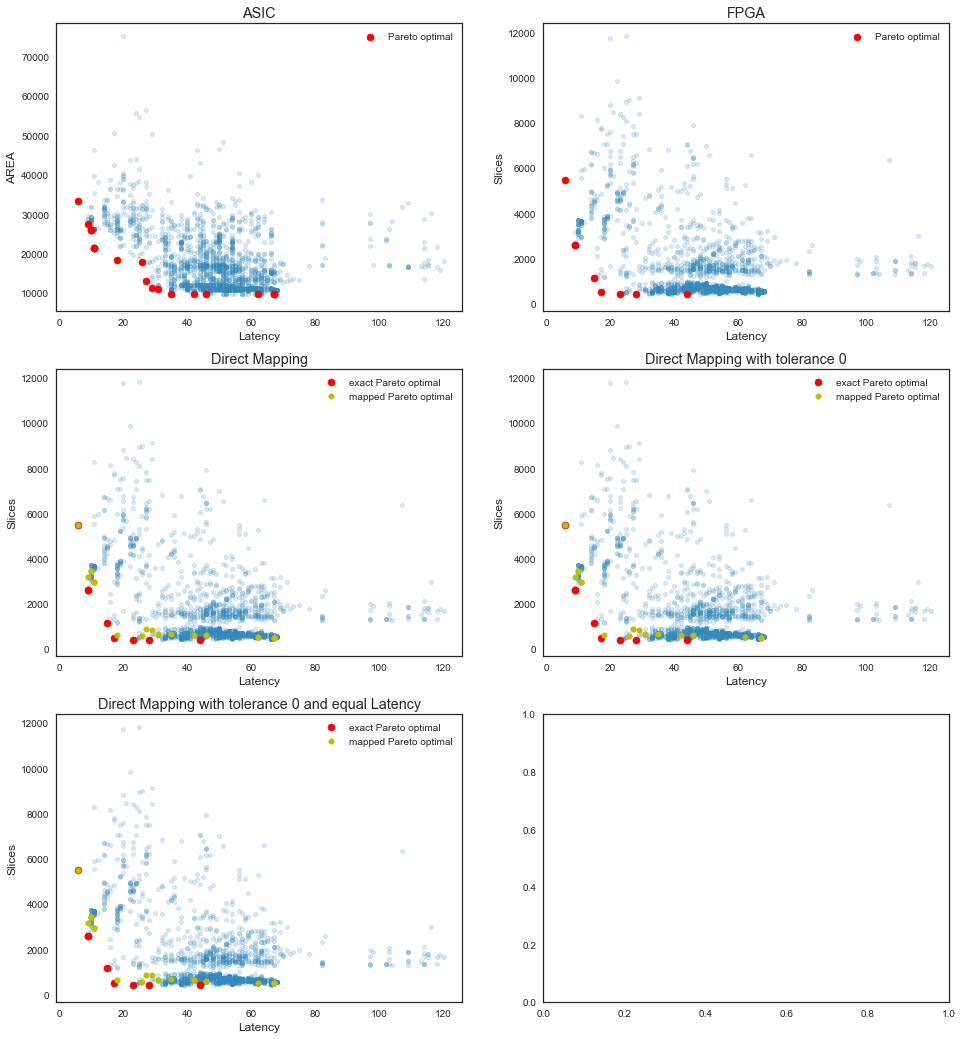

In [11]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(16, 18))

df.plot(kind='scatter', x='Latency', y='AREA', alpha=0.2, ax=axes[0, 0])
df.loc[df.PF_ASIC].plot(kind='scatter', x='Latency', y='AREA', color='r', s=50, ax=axes[0, 0], label='Pareto optimal')
axes[0, 0].set_title('ASIC')

df.plot(kind='scatter', x='Latency', y='Slices', alpha=0.2, ax=axes[0, 1])
df.loc[df.PF_FPGA].plot(kind='scatter', x='Latency', y='Slices', color='r', s=50, ax=axes[0, 1], label='Pareto optimal')
axes[0, 1].set_title('FPGA')

df.plot(kind='scatter', x='Latency', y='Slices', alpha=0.2, ax=axes[1, 0])
df.loc[df.PF_FPGA].plot(kind='scatter', x='Latency', y='Slices', color='r', s=50, ax=axes[1, 0], label='exact Pareto optimal')
df.loc[df.PF_ASIC].plot(kind='scatter', x='Latency', y='Slices', color='y', s=30, ax=axes[1, 0], label='mapped Pareto optimal')
axes[1, 0].set_title('Direct Mapping')

df.plot(kind='scatter', x='Latency', y='Slices', alpha=0.2, ax=axes[1, 1])
df.loc[df.PF_FPGA].plot(kind='scatter', x='Latency', y='Slices', color='r', s=50, ax=axes[1, 1], label='exact Pareto optimal')
df.loc[df.WithTolerance].plot(kind='scatter', x='Latency', y='Slices', color='y', s=30, ax=axes[1, 1], label='mapped Pareto optimal')
axes[1, 1].set_title(f'Direct Mapping with tolerance {with_tolerance}')

df.plot(kind='scatter', x='Latency', y='Slices', alpha=0.2, ax=axes[2, 0])
df.loc[df.PF_FPGA].plot(kind='scatter', x='Latency', y='Slices', color='r', s=50, ax=axes[2, 0], label='exact Pareto optimal')
df.loc[df.WithToleranceL].plot(kind='scatter', x='Latency', y='Slices', color='y', s=30, ax=axes[2, 0], label='mapped Pareto optimal')
axes[2, 0].set_title(f'Direct Mapping with tolerance {with_tolerance} and equal Latency')

plt.show()

**==============================**

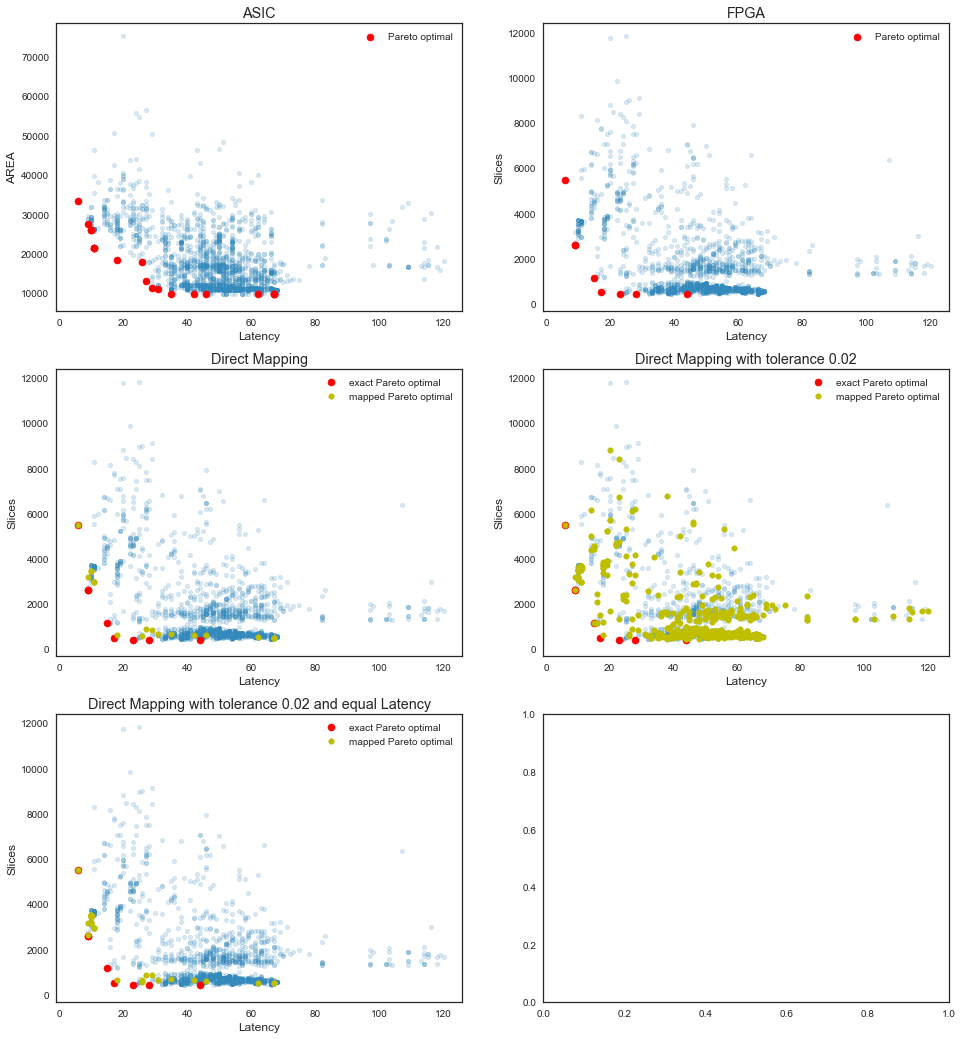

In [12]:
dm = DirectMapping()
dm.main(df, tolerance=0.02, plot_figure=True)

In [13]:
dm.results_no_tol

{'adrs_ave': 0.25747664042397966,
 'adrs_ave_rms': 0.16457923841384486,
 'adrs_max': 0.39851485148514854,
 'adrs_max_rms': 0.24543360236390221,
 'cardinality': 15,
 'dominance': 0.14285714285714285,
 'hypervolume': 0.5815688281237367}

In [14]:
dm.results_tol_eq_l

{'adrs_ave': 0.2273289331929391,
 'adrs_ave_rms': 0.14622586994900286,
 'adrs_max': 0.39851485148514854,
 'adrs_max_rms': 0.24543360236390221,
 'cardinality': 19,
 'dominance': 0.14285714285714285,
 'hypervolume': 0.6005881262629639}

In [15]:
dm.results_tol

{'adrs_ave': 0.11859748917153749,
 'adrs_ave_rms': 0.028258490264379998,
 'adrs_max': 0.354916067146283,
 'adrs_max_rms': 0.055464520108021484,
 'cardinality': 631,
 'dominance': 0.2857142857142857,
 'hypervolume': 0.36555409809871364}